# Detroit Land Bank Authority (DLBA) Boarding Model

Geoff Perrin - 01.16.18

- This notebook is to predict whether or not a (single family residential) house in Detroit should be boarded by the city or not, based on historical boarding decisions made by the city (i.e. labelled data I've receieved from the Detroit Land Bank Authority (DLBA) in the form of housing surveys, as well as the Motor City Mapping housing survey done in 2014-2016.

In [1]:
#import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

np.random.seed(222)
%matplotlib inline

In [2]:
#import machine learning / classification libraries
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RFC
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import r2_score

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#import machine learning / regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [4]:
rf_param_grid = {'max_depth': [20], 'n_estimators': np.arange(500,502,100)}
#rf_param_grid = {'max_depth': [10, 20, 30], 'n_estimators': np.arange(401,602,100)}

In [5]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import losses,optimizers,metrics,activations
from keras.optimizers import SGD

Using TensorFlow backend.


In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [7]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

### Load Datasets

In [8]:
data = '../data/OccModelTrainingData_20170901/'
data_gtj = '../data/'
data_all = '../data/'

#### GTJ Survey Data

GTP Note 1-16-18: 

one strategy is to use GTJ data as labelled data - if "GTJ Property Secure" is "No", then boarding is needed.

In [9]:
gtj_df_raw = pd.read_csv(data_gtj + 'MostRecentGTJSurvey_20180112.csv')

In [10]:
gtj_df = gtj_df_raw[['Parcel ID', 'Property: Property Class', 'Property: Program', 'Status', 'GTJ Survey Complete', 'GTJ Property Secure']]

In [11]:
gtj_df.columns = ['Ref_ID', 'property_class', 'program', 'status', 'survey_complete_date', 'boarding_needed']

In [12]:
gtj_df['survey_complete_date'] = gtj_df['survey_complete_date'].apply(pd.to_datetime)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
def year_date(x):
    return x.year

In [14]:
#just subset to houses surveyed since beginning of 2016
gtj_df['year'] = gtj_df['survey_complete_date'].apply(year_date)
gtj_df = gtj_df[gtj_df.year >= 2016]

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
#subset to just residential-structures
gtj_df = gtj_df[gtj_df['property_class'] == 'Residential-Structure']

In [16]:
gtj_df.groupby(['year'], as_index=False)['Ref_ID'].count()

,year,Ref_ID
0,2016.0,14677
1,2017.0,7161


In [17]:
def boarding_needed_flag(x):
    if x=='Yes':
        return 1
    else:
        return 0

In [18]:
gtj_df['boarding_needed_dummy'] = gtj_df['boarding_needed'].apply(boarding_needed_flag)

In [19]:
#final subset to just the columns we need
gtj_df = gtj_df[['Ref_ID', 'boarding_needed_dummy']]

### parcel points ownership Data

In [20]:
ppo_df = pd.read_csv(data_all + 'Parcel_Points_Ownership.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,23,24,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
ppo_df = ppo_df[['Parcel Number', 'Owner', 'SaleDate', 'Last Sale Price', \
                 'Last Terms of Sale', 'Land Value', 'SqFt', 'Floor Area']]

In [22]:
ppo_df.columns = ['Ref_ID', 'Owner', 'SaleDate', 'SalePrice', 'TermsOfSale',\
                 'LandValue', 'SqFt', 'FloorArea']

In [23]:
gtj_addy_df = gtj_df_raw[['Parcel ID', 'Address', 'Property: Property Class']]
gtj_addy_df.columns = ['Ref_ID', 'Address', 'property_class']

In [24]:
ppo_df = gtj_addy_df.merge(ppo_df, how='inner', on='Ref_ID')

In [25]:
### just keep residential-structures
ppo_df = ppo_df[ppo_df['property_class']=='Residential-Structure']

In [26]:
def ownership_regex_dummy(name_of_owner):
    try:
        m = re.search(r"LLC",name_of_owner) 
        if m.group()[0] is not None:
            return 1
        else:
            return 0
    except:
        return 0

In [27]:
ppo_df['LLC_Owner_dummy'] = ppo_df['Owner'].apply(ownership_regex_dummy)

In [28]:
def dollars_to_num(s):
    try:
        s = s.replace(',', '')
        s = s.replace('$', '')
        return pd.to_numeric(s, errors='coerce')
    except:
        return s

In [29]:
ppo_df['SalePrice'] = ppo_df['SalePrice'].apply(dollars_to_num)

In [30]:
def years_since_sale(date):
    now = datetime.datetime.now()
    return now.year - date.year

In [31]:
#convert saledate to datetime
ppo_df['SaleDate'] = ppo_df['SaleDate'].apply(pd.to_datetime)

In [32]:
ppo_df['years_since_sale'] = ppo_df['SaleDate'].apply(years_since_sale)

In [33]:
ppo_df = ppo_df[['Ref_ID', 'SalePrice', 'LandValue', 'SqFt', 'LLC_Owner_dummy']]

In [34]:
def pandas_to_numeric2(s):
    try:
        s = s.replace(',', '')
        return pd.to_numeric(s, errors='coerce')
    except:
        return s

In [35]:
def pandas_to_numeric(s):
    try:
        s = s.str.replace(',', '')
        return pd.to_numeric(s, errors='coerce')
    except:
        return s

In [36]:
ppo_df['LandValue'] = ppo_df['LandValue'].apply(pandas_to_numeric2)

#### Predict square footage based on sales price / landvalue

In [37]:
#drop rows where sqft is NaN or zero
sqft_df = ppo_df[~pd.isnull(ppo_df['SqFt'])]

In [38]:
sqft_df['SqFt'] = sqft_df['SqFt'].apply(pandas_to_numeric2)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
#subset to non-zero values
sqft_df = sqft_df[sqft_df['SqFt'] > 0]

#subset to non-ridiculous values
sqft_df = sqft_df[sqft_df['SqFt'] < 50000]

In [40]:
X = sqft_df.drop(['Ref_ID', 'SqFt'], axis=1)

In [41]:
y = sqft_df['SqFt']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
# use random forest to predict size_sqft
r_tree = RandomForestRegressor()
r_tree_tuned_sqft = GridSearchCV(r_tree, rf_param_grid)
r_tree_tuned_sqft.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([500]), 'max_depth': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
#explore feature importance
feature_importance = r_tree_tuned_sqft.best_estimator_.fit(X_train, y_train).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)
Feature_importance_df

,variables,importance
0,LandValue,0.789971
1,SalePrice,0.197223
2,LLC_Owner_dummy,0.0128063


In [45]:
#run accuracy metrics
predictions = r_tree_tuned_sqft.predict(X_test)
#RMSE
mean_squared_error(y_test, predictions)**0.5

1080.1986848084653

In [46]:
y_test.std()

1427.533821016304

In [47]:
r2_score(y_test, predictions)

0.4273429349045983

In [48]:
#apply model to full data
sqft_predict = ppo_df.drop(['Ref_ID', 'SqFt'], axis=1)

ppo_df['sqft_predict'] = r_tree_tuned_sqft.predict(sqft_predict)

ppo_df['SqFt'] = ppo_df['SqFt'].apply(pandas_to_numeric2)

In [49]:
#if missing size_sqft (or if it's zero), replace with predicted value
ppo_df['SqFt'][(pd.isnull(ppo_df['SqFt']) | (ppo_df['SqFt'] < 0.1))]\
= ppo_df['sqft_predict']
        
#drop predicted size_sqft
ppo_df = ppo_df.drop(['sqft_predict'], axis=1)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [50]:
ppo_df.head()

,Ref_ID,SalePrice,LandValue,SqFt,LLC_Owner_dummy
0,22030396.,1500.0,659,4008.0,0
1,21019298-9,96478.0,1682,7928.0,0
2,01004952.,0.0,816,4879.0,0
3,16023426.,2900.0,823,3790.0,0
4,21019661.,65291.0,915,4421.0,0


#### DTE data

In [51]:
dte_df = pd.read_csv(data + 'DTE_ActiveGasElectric_GeocoderMatches_20170920.txt')

In [52]:
dte_df = dte_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [53]:
### Deduplicate data
dte_df = dte_df.drop_duplicates()

In [54]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df = dte_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

#### DWSD (Water Department) data

In [55]:
dwsd_df = pd.read_csv(data + 'DWSD_12Mo_20170825.csv')

In [56]:
dwsd_df = dwsd_df[[u'REPAIREDPARCELID',
                   u'NINE', u'TEN', u'ELEVEN',
                   u'TWELVE', u'ONE', u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',
                   u'EIGHT']]

In [57]:
dwsd_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', u'TWO', u'THREE', \
              u'FOUR', u'FIVE', u'SIX', u'SEVEN',u'EIGHT']] \
            = dwsd_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', \
                            u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',\
                            u'EIGHT']].apply(pandas_to_numeric)

In [58]:
dwsd_df['year_total'] = dwsd_df.ONE + dwsd_df.TWO + dwsd_df.THREE + dwsd_df.FOUR +\
                        dwsd_df.FIVE + dwsd_df.SIX +dwsd_df.SEVEN + dwsd_df.EIGHT + dwsd_df.NINE +\
                        dwsd_df.TEN + dwsd_df.ELEVEN + dwsd_df.TWELVE

In [59]:
### sum water amounts of duplicate properties 
dwsd_df = dwsd_df.groupby(['REPAIREDPARCELID'], as_index=False)[ 
        u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', 
        u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', 
        u'SEVEN', u'EIGHT', u'year_total'].sum()

In [60]:
dwsd_df = dwsd_df.rename(columns={'REPAIREDPARCELID': 'Ref_ID'})

#### USPS / DFD (Fire Department) data

In [61]:
usps_df = pd.read_csv(data + 'DFD_USPS_20170829.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
usps_df.head()

,Account Name,Parcel ID,Property Class,USPS: Last Update,USPS: Vacancy Indicated,DFD Fire: Occurrence Date
0,2411 Wendell,20007595.,Residential-Structure,8/1/2017,No,8/19/2017
1,17208 Ohio,16033858.,Residential-Structure,8/1/2017,No,8/19/2017
2,60 E Euclid,01002534.,Residential-Structure,8/1/2017,No,8/19/2017
3,8154 W Lafayette,20002305.,Residential-Structure,8/1/2017,Yes,8/19/2017
4,16691 Fairmount Dr,21025509.001,Residential-Structure,8/1/2017,No,8/18/2017


In [63]:
usps_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date']

In [64]:
### subset to residential data
usps_df = usps_df[usps_df['Property Class'] == 'Residential-Structure']

In [65]:
### create DFD fire dummy
usps_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_df['DFD Fire: Occurrence Date']]

In [66]:
### create USPS occupied dummy
usps_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_df['USPS: Vacancy Indicated']]

In [67]:
### Just keep variables we need
usps_df = usps_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [68]:
vote_df = pd.read_csv(data + 'QVF_Detroit_Geo_20170717.txt')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [69]:
vote_df = vote_df[['Ref_ID']]
vote_df['vote_dummy'] = 1

In [70]:
vote_df = vote_df.drop_duplicates()

#### Blext data (Motor City Mapping data)
- https://motorcitymapping.org/#t=overview&s=detroit&f=all

In [71]:
mcm_df = pd.read_csv(data + 'Recent_Blexts_8_18_16_v2.csv')

In [72]:
mcm_df = mcm_df[[u'Account Name', u'Parcel ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']]

In [73]:
mcm_df.columns = [u'Account Name', u'Ref_ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']

In [74]:
### subset to residential data
mcm_df = mcm_df[mcm_df['Property Class'] == 'Residential-Structure']

In [75]:
### subset to non-lot properties
mcm_df = mcm_df[mcm_df['MCM Structure'] == 'Yes']

#### Note from Alice Hargreaves:

NOTE: code "maybe" or "partial" occupied houses as occupied... Ive googled a lot of the "maybes" and theyre nearly all structually sound --- i.e., someone could occupy it, but someone might not be sleeping there every night - GP line of thinking about 3k rows are "maybe" or "partial" 

(R-code below):

In [76]:
def occupancy_binary(x):
    if (x == "Occupied") | (x == "Unoccupied"):
        return x
    else:
        return "Occupied"

In [77]:
mcm_df['MCM Occupancy'] = mcm_df['MCM Occupancy'].apply(occupancy_binary)

In [78]:
### create DFD fire dummy
mcm_df['mcm_occupancy_dummy'] = [1 if x == 'Occupied' else 0 for x in mcm_df['MCM Occupancy']]

#### Blight Violations Data

In [79]:
blight_df_raw = pd.read_csv(data_all + 'Blight_Violations.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
blight_df_raw.head(1)

,Ticket ID,Ticket Number,Agency Name,Inspector Name,Violator Name,Violator ID,Violation Street Number,Violation Street Name,Violation Zip Code,Mailing Address Street Number,Mailing Address Street Name,Mailing Address City,Mailing Address State,Mailing Address Zip Code,Mailing Address Non-USA Code,Mailing Address Country,Violation Date,Ticket Issued Time,Hearing Date,Hearing Time,Violation Code,Violation Description,Disposition,Fine Amount,Admin Fee,State Fee,Late Fee,Discount Amount,Clean Up Cost,Judgment Amount (Total Due),Payment Amount (Sum of All Payments),Balance Due,Payment Date (Most Recent),Payment Status,Collection Status,Violation Address,Violation Parcel ID,Violation Latitude,Violation Longitude,Violation Location
0,287802,12044442DAH,Department of Public Works,Leah Jones,RICHARD ROSS,254088,8561,SUSSEX,NaN,340,W. 21ST AVE.,APACHE JUNCTION,AZ,85220,NaN,NaN,03/13/2012,1900-01-01T10:15:00,04/11/2012,9:00 AM,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,$500.00,$20.00,$10.00,$0.00,$0.00,NaN,$530.00,NaN,$530.00,NaN,NaN,In collections,8561 SUSSEX,22047069.,42.356743,-83.194154,"location\n(42.356742685, -83.19415431)"


In [81]:
blight_df = blight_df_raw[['Fine Amount', 'Violation Description', 'Violation Parcel ID']]

In [82]:
blight_df['Fine Amount'] = blight_df['Fine Amount'].apply(dollars_to_num)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [145]:
violation_df = blight_df.groupby(['Violation Description'], as_index=False)['Fine Amount'].count()
violation_df.columns = ['Violation Description', 'violation_count']

In [146]:
blight_df = blight_df.merge(violation_df, how='left', on='Violation Description')

In [173]:
#DROP ROWS WITH VIOLATIONS OF LESS THAN 200 violations total
blight_df = blight_df[blight_df.violation_count > 200]
blight_df.columns = ['fine_amount', 'Violation Description', 'Ref_ID', 'violation_count']
blight_df.head()

,fine_amount,Violation Description,Ref_ID,violation_count
0,500.0,Allowing bulk solid waste to lie or accumulate...,22047069.,34696.0
1,50.0,Excessive weeds or plant growth one- or two-fa...,15002111.,47907.0
2,50.0,Inoperable motor vehicle(s) one- or two-family...,18007081.,8776.0
3,50.0,Inoperable motor vehicle(s) one- or two-family...,22063920.,8776.0
4,50.0,Excessive weeds or plant growth one- or two-fa...,21061261.,47907.0


In [174]:
### Dummy for Violation
blight_df_w_dummies = pd.get_dummies(blight_df, prefix='violation_', columns=['Violation Description'], drop_first=False)

In [175]:
blight_df_w_dummies = blight_df_w_dummies.drop(['violation_count'], axis=1)

In [178]:
blight_df_w_dummies_sum = blight_df_w_dummies.groupby(['Ref_ID'], as_index=False).sum()

In [179]:
blight_df_w_dummies_sum.head()

,Ref_ID,fine_amount,violation__Allowing bulk solid waste to lie or accumulate on or about the premises,violation__Bulk solid waste deposited more than 24 hours before designated time,violation__Defective exterior wall(s) one- or two-family dwelling or commercial building,violation__Defective roof or drainage one- or two-family dwelling or commercial building,"violation__Depositing domestic or commercial solid waste in containers owned, assigned to, or contracted for, by other persons or premises","violation__Dumping, or deposting solid waste of five (5) cubic feet or more from any motor vehicle upon any public or private property or street","violation__Dumping, storing or depositing solid waste 5 or more cubic yards on any publicly-owned property, or private property or water, without a permit","violation__Dumping, storing or depositing solid waste on any publicly-owned property, or private property or water, without a permit",violation__Excessive weeds or plant growth one- or two-family dwelling or commercial Building,violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (1 or 2 family dwelling),violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (Buildings with five (5) or more stories),"violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (all other structures, except buildings with five (5) or more stories)","violation__Failed to comply with other land use or procedural requirements - Unlawful Sign, Banner or antenna",violation__Failed to obtain the required Certificate of registration for Vacant Building,violation__Failing to secure City or Private solid waste collection containers and services,violation__Failure of owner of a building with five (5) or more stories to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy,"violation__Failure of owner of any other structure, except buildings with five (5) or more stories, to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy",violation__Failure of owner of one- or two-family dwelling to comply with an emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy,violation__Failure of owner to comply with an emergency or imminent danger order of one- or two-family dwelling or building,"violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste","violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid, medical or hazardous waste",violation__Failure of owner to obtain certificate of compliance,violation__Failure of owner to remove graffiti or maintain or restore property free of graffiti.,violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (All structures except 1 or 2 family dwellings and buildings with 5 or more stories),violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (One or Two Family dwelling),violation__Failure to maintain accessory structure(s) one-or two- family dwelling or commercial building,"violation__Failure to maintain balcony, deck, porch, or stairway one- or two-family dwelling or commercial building","violation__Failure to maintain exterior of one- or two-family dwelling, building, premises or commercial structure in good repair, structurally sound or in a sanitary condition to prevent threat to the public health, safety or welfare",violation__Failure to maintain vacant one- or two- family dwelling or building,violation__Failure to obtain Ce

### Merge Datasets together

In [180]:
# merge gtj data with usps / dfd data
merged_train = gtj_df.merge(usps_df, how='left', on='Ref_ID')

In [181]:
#merge on voter (qvf) data
merged_train2 = merged_train.merge(vote_df, how='left', on='Ref_ID')

In [182]:
#fill in NaNs for vote_dummy
merged_train2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_train2['vote_dummy']]

In [183]:
#merge on dwsd data
merged_train3 = merged_train2.merge(dwsd_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_train3.fillna(value=0,inplace=True)

In [184]:
#merge on parcel points ownership data
merged_train4 = merged_train3.merge(ppo_df, how='left', on='Ref_ID')

In [185]:
#merge on dte data
merged_train5 = merged_train4.merge(dte_df, how='left', on='Ref_ID')

In [186]:
#merge on blight fine data
merged_train_final = merged_train5.merge(blight_df_w_dummies_sum, how='left', on='Ref_ID')
merged_train_final.fillna(value=0,inplace=True)

In [187]:
merged_train_final.head()

,Ref_ID,boarding_needed_dummy,fire_occured_dummy,usps_occupied_dummy,vote_dummy,NINE,TEN,ELEVEN,TWELVE,ONE,TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,year_total,SalePrice,LandValue,SqFt,LLC_Owner_dummy,gas_dummy,electric_dummy,fine_amount,violation__Allowing bulk solid waste to lie or accumulate on or about the premises,violation__Bulk solid waste deposited more than 24 hours before designated time,violation__Defective exterior wall(s) one- or two-family dwelling or commercial building,violation__Defective roof or drainage one- or two-family dwelling or commercial building,"violation__Depositing domestic or commercial solid waste in containers owned, assigned to, or contracted for, by other persons or premises","violation__Dumping, or deposting solid waste of five (5) cubic feet or more from any motor vehicle upon any public or private property or street","violation__Dumping, storing or depositing solid waste 5 or more cubic yards on any publicly-owned property, or private property or water, without a permit","violation__Dumping, storing or depositing solid waste on any publicly-owned property, or private property or water, without a permit",violation__Excessive weeds or plant growth one- or two-family dwelling or commercial Building,violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (1 or 2 family dwelling),violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (Buildings with five (5) or more stories),"violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (all other structures, except buildings with five (5) or more stories)","violation__Failed to comply with other land use or procedural requirements - Unlawful Sign, Banner or antenna",violation__Failed to obtain the required Certificate of registration for Vacant Building,violation__Failing to secure City or Private solid waste collection containers and services,violation__Failure of owner of a building with five (5) or more stories to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy,"violation__Failure of owner of any other structure, except buildings with five (5) or more stories, to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy",violation__Failure of owner of one- or two-family dwelling to comply with an emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy,violation__Failure of owner to comply with an emergency or imminent danger order of one- or two-family dwelling or building,"violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste","violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid, medical or hazardous waste",violation__Failure of owner to obtain certificate of compliance,violation__Failure of owner to remove graffiti or maintain or restore property free of graffiti.,violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (All structures except 1 or 2 family dwellings and buildings with 5 or more stories),violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (One or Two Family dwelling),violation__Failure to maintain accessory structure(s) one-or two- family dwelling or commercial building,"violation__Failure to maintain balcony, deck, porch, or stairway one- or two-family dwelling or commercial building","violation__Failure to maintain exterior of one- or two-family dwelling, building, premises or commercial structure in good repair, str

In [198]:
merged_train_final.columns

Index([                                                                                                                                                                                                                                        u'Ref_ID',
                                                                                                                                                                                                                                u'boarding_needed_dummy',
                                                                                                                                                                                                                                   u'fire_occured_dummy',
                                                                                                                                                                                                                                  u'usps_occupied_dummy',


In [189]:
len(merged_train_final)

21871

### Visualize Data

In [192]:
data_corr = merged_train_final[['boarding_needed_dummy', u'fire_occured_dummy', 
                                u'usps_occupied_dummy',
                                u'vote_dummy',  u'NINE',                  u'TEN',
                     u'ELEVEN',               u'TWELVE',
                        u'ONE',                  u'TWO',
                      u'THREE',                 u'FOUR',
                       u'FIVE',                  u'SIX',
                      u'SEVEN',                u'EIGHT', u'year_total', u'gas_dummy', u'electric_dummy',
                    u'SalePrice', u'LandValue', u'SqFt', u'LLC_Owner_dummy', u'fine_amount']]

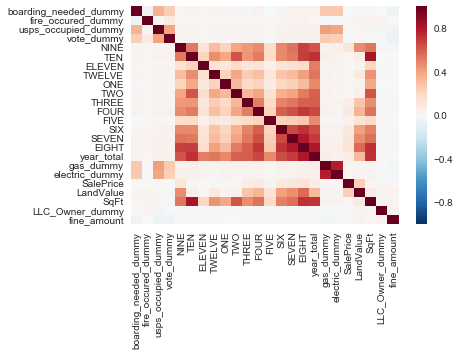

In [193]:
sns.heatmap(data_corr.corr(), annot=False)

In [196]:
data_corr2 = merged_train_final[['boarding_needed_dummy', 
                                 u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy',
                                u'SalePrice', u'LandValue', 
                                u'fine_amount', 'SqFt']]

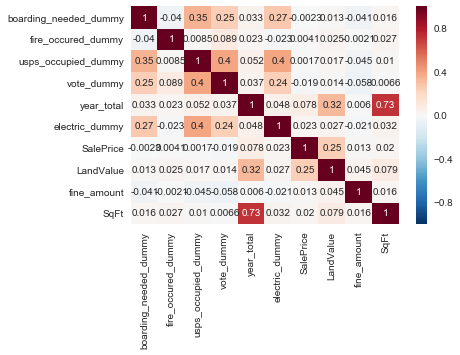

In [197]:
sns.heatmap(data_corr2.corr(), annot=True)

In [199]:
data_corr3 = merged_train_final[['boarding_needed_dummy', u'violation__Allowing bulk solid waste to lie or accumulate on or about the premises',
                                                                                                                                                                      u'violation__Bulk solid waste deposited more than 24 hours before designated time',
                                                                                                                                                             u'violation__Defective exterior wall(s) one- or two-family dwelling or commercial building',
                                                                                                                                                             u'violation__Defective roof or drainage one- or two-family dwelling or commercial building',
                                                                                                           u'violation__Depositing domestic or commercial solid waste in containers owned, assigned to, or contracted for, by other persons or premises',
                                                                                                    u'violation__Dumping,  or deposting solid waste of five (5) cubic feet or more from any motor vehicle upon any public or private property or street',
                                                                                          u'violation__Dumping, storing or depositing solid waste 5 or more cubic yards on any publicly-owned property, or private property or water, without a permit ',
                                                                                                                 u'violation__Dumping, storing or depositing solid waste on any publicly-owned property, or private property or water, without a permit',
                                                                                                                                                        u'violation__Excessive weeds or plant growth one- or two-family dwelling or commercial Building',
                                                                                    u'violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (1 or 2 family dwelling)',
                                                                   u'violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (Buildings with five (5) or more stories)',
                                      u'violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (all other structures, except buildings with five (5) or more stories)',
                                                                                                                                        u'violation__Failed to comply with other land use or procedural requirements - Unlawful Sign, Banner or antenna',
                                                                                                                                                             u'violation__Failed to obtain the required Certificate of registration for Vacant Building',
                                                                                                                                                          u'violation__Failing to secure City or Private solid waste collection containers and services',
                                                      u'violation__Failure of owner of a building with five (5) or more stories to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy',
                          u'violation__Failure of owner of any other structure, except buildings with five (5) or more stories, to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy',
                                                                  u'violation__Failure of owner of one- or two-family dwelling to comply with an emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy',
                                                                                                                          u'violation__Failure of owner to comply with an emergency or imminent danger order of one- or two-family dwelling or building',
                                                                                                                                      u'violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste',
                                                                                                                u'violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid, medical or hazardous waste',
                                                                                                                                                                                      u'violation__Failure of owner to obtain certificate of compliance',
                                                                                                                                                     u'violation__Failure of owner to remove graffiti or maintain or restore property free of graffiti.',
       u'violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (All structures except 1 or 2 family dwellings and buildings with 5 or more stories)',
                                                               u'violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (One or Two Family dwelling)',
                                                                                                                                             u'violation__Failure to maintain accessory structure(s) one-or two- family dwelling or commercial building',
                                                                                                                                  u'violation__Failure to maintain balcony, deck, porch, or stairway one- or two-family dwelling or commercial building',
           u'violation__Failure to maintain exterior of one- or two-family dwelling, building, premises or commercial structure in good repair, structurally sound or in a sanitary condition to prevent threat to the public health, safety or welfare',
                                                                                                                                                                       u'violation__Failure to maintain vacant one- or two- family dwelling or building',
                                                                                                                                                                           u'violation__Failure to obtain Certificate of Compliance for rental property',
                                                                                                                                                       u'violation__Failure to obtain a lead clearance for rental property - one or two-family dwelling',
                                                                                                                 u'violation__Failure to obtain a permit for large movable or stationary container prior to the installation on any public right-of-way',
                                                                                                                                                                         u'violation__Failure to obtain certificate of registration for rental property',
                                                                                                                                                                       u'violation__Failure to obtain the certificate of Compliance for Vacant Building',
                                                                                                                                                                                 u'violation__Failure to remove animal waste on public/private property',
                                                                                                                                                          u'violation__Failure to secure City or Private solid waste collection containers and services',
                                                                                                                                                                             u'violation__Improper placement of Courville container between collections',
                                                                                                                                                                         u'violation__Improper storage and separation of solid waste for collection day',
                                                                                                                                                            u'violation__Inoperable motor vehicle(s) one- or two-family dwelling or commercial building',
                                                                                                                                                                                       u'violation__Open Storage/ Residential/ Inoperable Vehicles (R1)',
                                                                                                                                                                                                    u'violation__Removal of snow and ice from sidewalks',
                                                                                                                                                                        u'violation__Rodent harborage one-or two-family dwelling or commercial building',
                                                                                                                                                   u'violation__Unlawful accumulation of solid waste one- or two-family dwelling or commercial building',
                                                                                                                                                                                                u'violation__Unlawful change of use of building or land',
                                                                                                     u'violation__Unlawful occupation of rental property without lead clearance -  all other structures, except buildings with five (5) or more stories',
                                                                                                                                                u'violation__Unlawful occupation of rental property without lead clearance - one or two-family dwelling',
                                                                                                                                                     u'violation__Violation of time limit for approved containers to remain at curbside - early or late']]

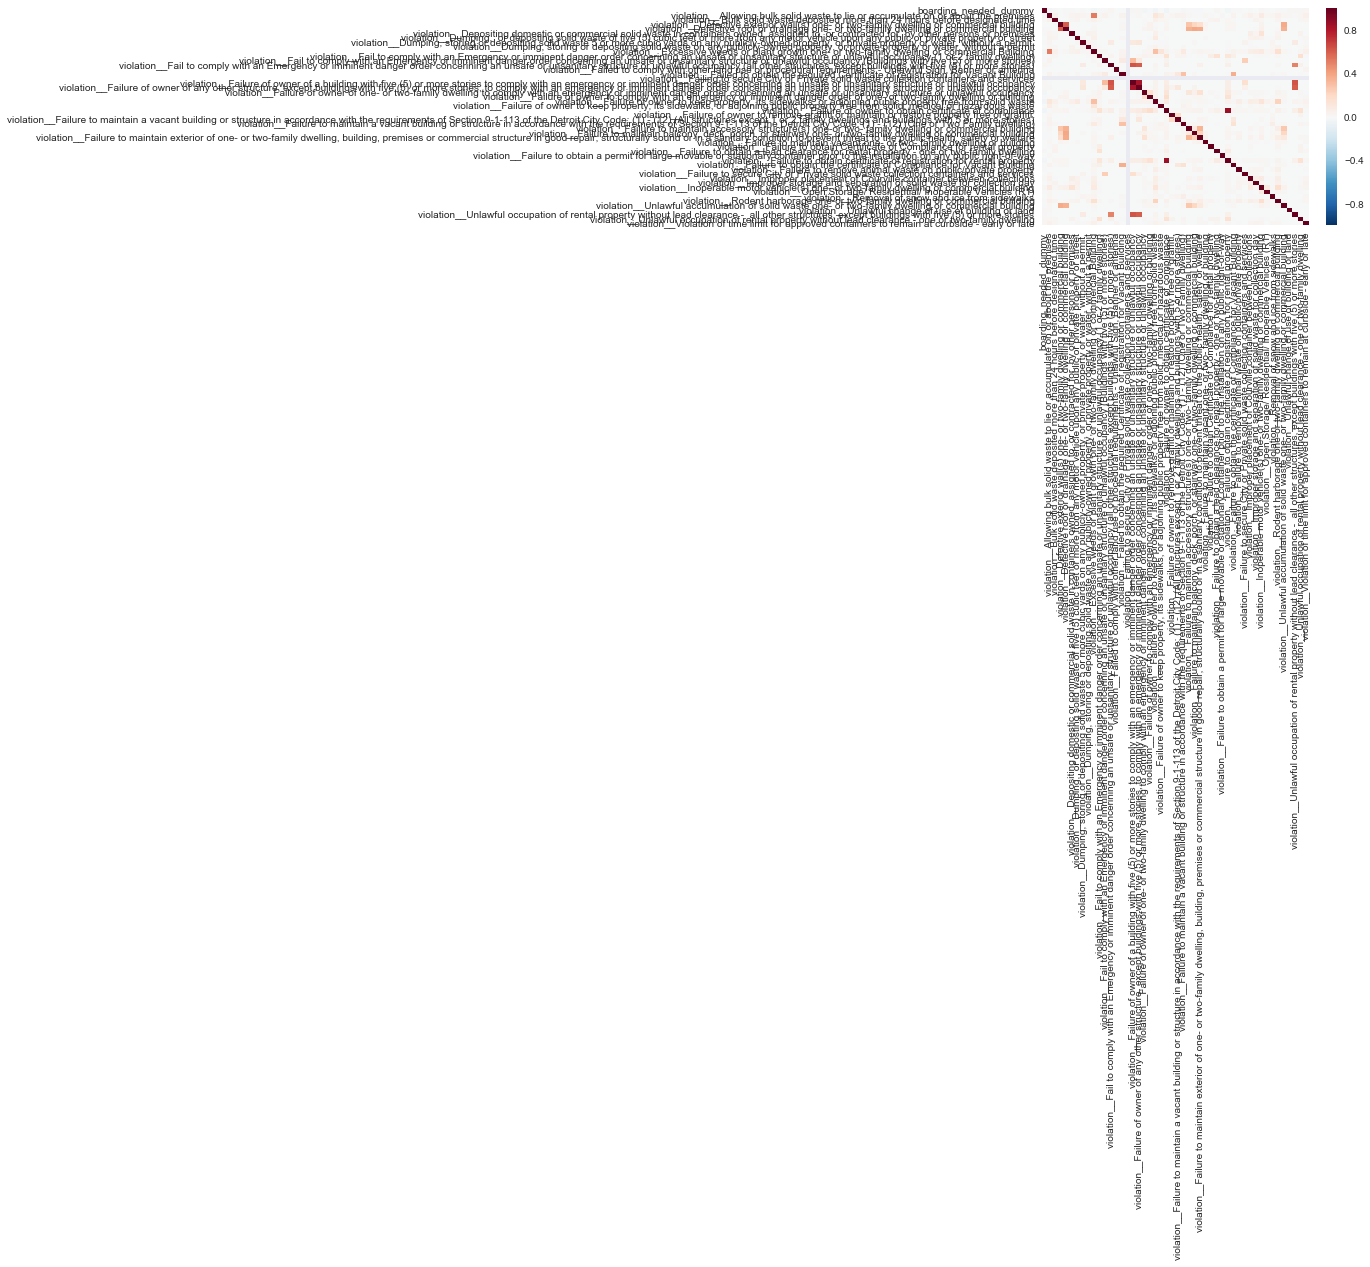

In [201]:
sns.heatmap(data_corr3.corr(), annot=False)

## Classification

In [202]:
merged_train_final.columns

Index([                                                                                                                                                                                                                                        u'Ref_ID',
                                                                                                                                                                                                                                u'boarding_needed_dummy',
                                                                                                                                                                                                                                   u'fire_occured_dummy',
                                                                                                                                                                                                                                  u'usps_occupied_dummy',


In [203]:
X = merged_train_final[[u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy',
                                u'SalePrice', u'LandValue', 
                                u'fine_amount', 'SqFt',
                        u'violation__Allowing bulk solid waste to lie or accumulate on or about the premises',
                                                                                                                                                                      u'violation__Bulk solid waste deposited more than 24 hours before designated time',
                                                                                                                                                             u'violation__Defective exterior wall(s) one- or two-family dwelling or commercial building',
                                                                                                                                                             u'violation__Defective roof or drainage one- or two-family dwelling or commercial building',
                                                                                                           u'violation__Depositing domestic or commercial solid waste in containers owned, assigned to, or contracted for, by other persons or premises',
                                                                                                    u'violation__Dumping,  or deposting solid waste of five (5) cubic feet or more from any motor vehicle upon any public or private property or street',
                                                                                          u'violation__Dumping, storing or depositing solid waste 5 or more cubic yards on any publicly-owned property, or private property or water, without a permit ',
                                                                                                                 u'violation__Dumping, storing or depositing solid waste on any publicly-owned property, or private property or water, without a permit',
                                                                                                                                                        u'violation__Excessive weeds or plant growth one- or two-family dwelling or commercial Building',
                                                                                    u'violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (1 or 2 family dwelling)',
                                                                   u'violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (Buildings with five (5) or more stories)',
                                      u'violation__Fail to comply with an Emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy (all other structures, except buildings with five (5) or more stories)',
                                                                                                                                        u'violation__Failed to comply with other land use or procedural requirements - Unlawful Sign, Banner or antenna',
                                                                                                                                                             u'violation__Failed to obtain the required Certificate of registration for Vacant Building',
                                                                                                                                                          u'violation__Failing to secure City or Private solid waste collection containers and services',
                                                      u'violation__Failure of owner of a building with five (5) or more stories to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy',
                          u'violation__Failure of owner of any other structure, except buildings with five (5) or more stories, to comply with an emergency or imminent danger order concerning an unsafe or unsanitary structure or unlawful occupancy',
                                                                  u'violation__Failure of owner of one- or two-family dwelling to comply with an emergency or imminent danger order concerining an unsafe or unsanitary structure or unlawful occupancy',
                                                                                                                          u'violation__Failure of owner to comply with an emergency or imminent danger order of one- or two-family dwelling or building',
                                                                                                                                      u'violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste',
                                                                                                                u'violation__Failure of owner to keep property, its sidewalks, or adjoining public property free from solid, medical or hazardous waste',
                                                                                                                                                                                      u'violation__Failure of owner to obtain certificate of compliance',
                                                                                                                                                     u'violation__Failure of owner to remove graffiti or maintain or restore property free of graffiti.',
       u'violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (All structures except 1 or 2 family dwellings and buildings with 5 or more stories)',
                                                               u'violation__Failure to maintain a vacant building or structure in accordance with the requirements of Section 9-1-113 of the Detroit City Code: (1) - (12) (One or Two Family dwelling)',
                                                                                                                                             u'violation__Failure to maintain accessory structure(s) one-or two- family dwelling or commercial building',
                                                                                                                                  u'violation__Failure to maintain balcony, deck, porch, or stairway one- or two-family dwelling or commercial building',
           u'violation__Failure to maintain exterior of one- or two-family dwelling, building, premises or commercial structure in good repair, structurally sound or in a sanitary condition to prevent threat to the public health, safety or welfare',
                                                                                                                                                                       u'violation__Failure to maintain vacant one- or two- family dwelling or building',
                                                                                                                                                                           u'violation__Failure to obtain Certificate of Compliance for rental property',
                                                                                                                                                       u'violation__Failure to obtain a lead clearance for rental property - one or two-family dwelling',
                                                                                                                 u'violation__Failure to obtain a permit for large movable or stationary container prior to the installation on any public right-of-way',
                                                                                                                                                                         u'violation__Failure to obtain certificate of registration for rental property',
                                                                                                                                                                       u'violation__Failure to obtain the certificate of Compliance for Vacant Building',
                                                                                                                                                                                 u'violation__Failure to remove animal waste on public/private property',
                                                                                                                                                          u'violation__Failure to secure City or Private solid waste collection containers and services',
                                                                                                                                                                             u'violation__Improper placement of Courville container between collections',
                                                                                                                                                                         u'violation__Improper storage and separation of solid waste for collection day',
                                                                                                                                                            u'violation__Inoperable motor vehicle(s) one- or two-family dwelling or commercial building',
                                                                                                                                                                                       u'violation__Open Storage/ Residential/ Inoperable Vehicles (R1)',
                                                                                                                                                                                                    u'violation__Removal of snow and ice from sidewalks',
                                                                                                                                                                        u'violation__Rodent harborage one-or two-family dwelling or commercial building',
                                                                                                                                                   u'violation__Unlawful accumulation of solid waste one- or two-family dwelling or commercial building',
                                                                                                                                                                                                u'violation__Unlawful change of use of building or land',
                                                                                                     u'violation__Unlawful occupation of rental property without lead clearance -  all other structures, except buildings with five (5) or more stories',
                                                                                                                                                u'violation__Unlawful occupation of rental property without lead clearance - one or two-family dwelling',
                                                                                                                                                     u'violation__Violation of time limit for approved containers to remain at curbside - early or late']]
y = merged_train_final.boarding_needed_dummy

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [205]:
len(X_train)

15309

### Class imbalance correction

In [206]:
merged_train_final.groupby(['boarding_needed_dummy'], as_index=False)['fire_occured_dummy'].count()

,boarding_needed_dummy,fire_occured_dummy
0,0,15340
1,1,6531


### Logistic Classification

In [207]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [208]:
predictions = logmodel.predict(X_test)

In [209]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.70      1.00      0.82      4591
          1       0.80      0.01      0.02      1971

avg / total       0.73      0.70      0.58      6562



In [210]:
print(roc_auc_score(y_test, predictions))

0.5054348276539997


### use Over Sampling to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [211]:
ros = RandomOverSampler(random_state=0, ratio='minority')
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [212]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [213]:
predictions = logmodel.predict(X_test)

In [214]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.79      0.79      4591
          1       0.52      0.54      0.53      1971

avg / total       0.72      0.71      0.71      6562



In [215]:
print(roc_auc_score(y_test, predictions))

0.6643054855191167


### Use SMOTE to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [216]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

### Random Forest

In [217]:
r_tree = RFC()

In [218]:
param_grid = {'max_depth': [9, 11, 13, 15, 17], 'n_estimators': np.arange(1,602,100)}
r_tree_tuned = GridSearchCV(r_tree, param_grid)
r_tree_tuned.fit(X_resampled, y_resampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1, 101, 201, 301, 401, 501, 601]), 'max_depth': [9, 11, 13, 15, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [219]:
feature_importance = r_tree_tuned.best_estimator_.fit(X_resampled, y_resampled).feature_importances_

In [220]:
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)

In [221]:
Feature_importance_df

,variables,importance
0,usps_occupied_dummy,0.226972
1,vote_dummy,0.178311
2,electric_dummy,0.102446
3,violation__Excessive weeds or plant growth one...,0.0566924
4,SqFt,0.0545483
5,LandValue,0.054462
6,SalePrice,0.0502649
7,fine_amount,0.0413132
8,fire_occured_dummy,0.0367833
9,violation__Allowing bulk solid waste to lie or...,0.0355431


In [222]:
r_tree_tuned.best_params_

{'max_depth': 17, 'n_estimators': 301}

### Final Model Evaluation

### Model Evaluation:

- we want to minimize homes being misclassified as unoccupied when they are really occupied
- this means we want to maximize the precision of 0 (unoccupied) as that minimizes the statement above
- False Negative of 0 means a home is classified as being occupied but is really unoccupied

<img src="Precisionrecall.png",width=300,height=300>

In [223]:
predictions = r_tree_tuned.predict(X_test)
predict_probability = r_tree_tuned.predict_proba(X_test)[:,1]

In [224]:
accuracy(y_test, predictions)

0.7581530021334959

In [225]:
def bool_to_num(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v

In [228]:
print(roc_auc_score(y_test, predictions))

0.6475027630549303


In [230]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.77      0.92      0.84      4591
          1       0.68      0.37      0.48      1971

avg / total       0.75      0.76      0.73      6562



## Read in full data

In [ ]:
data_full = '../data/OccModel_FittingFullData_20170922/'

#### DTE data

In [ ]:
dte_full_df = pd.read_csv(data_full + 'DTE_ActiveGasElectric_GeocoderMatches_20170920.txt')

In [ ]:
dte_full_df = dte_full_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [ ]:
### Deduplicate data
dte_full_df = dte_full_df.drop_duplicates()

In [ ]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_full_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df = dte_full_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

In [ ]:
len(dte_full_df)

#### DWSD (Water Department) data

In [ ]:
dwsd_full_df = pd.read_csv(data_full + 'DWSD_12Mo_20170825.csv')

In [ ]:
dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', u'TWO', u'THREE', \
              u'FOUR', u'FIVE', u'SIX', u'SEVEN',u'EIGHT']] \
            = dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', \
                            u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',\
                            u'EIGHT']].apply(pandas_to_numeric)

In [ ]:
dwsd_full_df['year_total'] = dwsd_full_df.NINE + dwsd_full_df.TEN + dwsd_full_df.ELEVEN + \
                             dwsd_full_df.TWELVE + dwsd_full_df.ONE + dwsd_full_df.TWO + \
                             dwsd_full_df.THREE + dwsd_full_df.FOUR + dwsd_full_df.FIVE + \
                             dwsd_full_df.SIX + dwsd_full_df.SEVEN + dwsd_full_df.EIGHT

In [ ]:
dwsd_full_df = dwsd_full_df[['REPAIREDPARCELID', u'year_total']]

In [ ]:
dwsd_full_df.columns = ['Ref_ID', 'year_total']

In [ ]:
### sum water amounts of duplicate properties 
dwsd_full_df = dwsd_full_df.groupby(['Ref_ID'], as_index=False)[ u'year_total'].sum()

#### USPS / DFD (Fire Department) data

In [ ]:
usps_full_df = pd.read_csv(data_full + 'DFD_USPS_20170829.csv')

In [ ]:
usps_full_df.head()

In [ ]:
usps_full_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date',]

In [ ]:
### subset to residential data
usps_full_df = usps_full_df[usps_full_df['Property Class'] == 'Residential-Structure']

In [ ]:
### create DFD fire dummy
usps_full_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_full_df['DFD Fire: Occurrence Date']]

In [ ]:
### create USPS occupied dummy
usps_full_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_full_df['USPS: Vacancy Indicated']]

In [ ]:
### Just keep variables we need
usps_full_df = usps_full_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [ ]:
vote_full_df = pd.read_csv(data_full + 'QVF_Detroit_Geo_20170717.txt')

In [ ]:
vote_full_df = vote_full_df[['Ref_ID']]
vote_full_df['vote_dummy'] = 1

In [ ]:
vote_full_df = vote_full_df.drop_duplicates()

#### Address Data

In [ ]:
addy_full_df = pd.read_csv(data_full + 'ResStructureParcelsAccountIDs_20170920.csv')

In [ ]:
addy_full_df.head()

In [ ]:
### subset to residential data
addy_full_df = addy_full_df[addy_full_df['Property Class'] == 'Residential-Structure']

In [ ]:
addy_full_df.columns = ['Account_ID', 'Ref_ID', 'Account_Name', 'Property_Ownership', 'Property_Class']

In [ ]:
len(addy_full_df)

### Merge Datasets together

In [ ]:
# merge mcm data with usps / dfd data
merged_full = addy_full_df.merge(usps_full_df, how='left', on='Ref_ID')

In [ ]:
#merge on voter (qvf) data
merged_full2 = merged_full.merge(vote_full_df, how='left', on='Ref_ID')

In [ ]:
#fill in NaNs for vote_dummy
merged_full2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_full2['vote_dummy']]

In [ ]:
#merge on dwsd data
merged_full3 = merged_full2.merge(dwsd_full_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_full3.fillna(value=0,inplace=True)

In [ ]:
#merge on dte data
merged_full_final = merged_full3.merge(dte_full_df, how='left', on='Ref_ID')
merged_full_final.fillna(value=0,inplace=True)

In [ ]:
merged_full_final.head()

In [ ]:
merged_full_final.columns

## Applying Predictions to full dataset

In [ ]:
X.columns

In [ ]:
merged_full_final.copy()[['fire_occured_dummy', u'usps_occupied_dummy', u'vote_dummy',
                u'year_total', u'electric_dummy']].head()

In [ ]:
predictions_df = merged_full_final.copy()[['fire_occured_dummy', u'usps_occupied_dummy', u'vote_dummy',
                u'year_total', u'electric_dummy']]

In [ ]:
merged_full_final['prediction_occupancy'] = r_tree_tuned.predict(predictions_df)
merged_full_final['prediction_occupancy_proba'] = r_tree_tuned.predict_proba(predictions_df)[:,1]

In [ ]:
merged_full_final.head()

### Investigating Final Housing Statistics

#### Number of occupied homes in Detroit

In [ ]:
len(merged_full_final)

In [ ]:
sum(merged_full_final.prediction_occupancy)

In [ ]:
sum(merged_full_final.prediction_occupancy) * 1.0 / len(merged_full_final)

#### Number of occupied homes owned by DLBA

In [ ]:
merged_full_final.groupby(['Property_Ownership'])['prediction_occupancy'].sum()

In [ ]:
merged_full_final.groupby(['Property_Ownership'])['prediction_occupancy'].count()

In [ ]:
3293*1.0 / 31146

## Export Final Data

In [ ]:
# to .csv
#merged_full_final.to_csv('OPM_output_final.csv', sep='\t')

In [ ]:
merged_full_final.head()

In [ ]:
### export just DLBA properties
DLBA_final = merged_full_final[merged_full_final.Property_Ownership=='DLBA Owned']

In [ ]:
DLBA_final.head()

In [ ]:
#DLBA_final.to_csv('OPM_output_final_DLBA.csv', sep='\t')